# Abstract

In this analysis, we will be looking at data from an experiment that exposed mice to visual stimuli and recorded their responses to that stimuli. After examining the data, we will be creating a prediction model to predict the responses of 200 random trials. Finally, we will be evaluating the performance of the model and discussing how we can further improve it.

# Introduction

This project is derived from a 2019 experiment by Nicholas A. Steinmetz, Peter Zatka-Haas, Matteo Carandini, and Kenneth D. Harris on neural activity in mice when presented with a situation in which the mice needed to make a choice.

The link to the full article can be found here: https://www.nature.com/articles/s41586-019-1787-x

This analysis seeks to construct a predictive model that can be used to predict the mice feedback given certain stimuli (represented by left and right contrasts) and neuron activity (represented by spike trains in certain areas of the brain). This model can be used to extend the results of the analysis to different species with similar brain region makeup without having to go through any invasive probing. 

First, we will explore the data and quantify the variables in order to identify patterns and relationships. Next, we will attempt to integrate the data across the different trial sessions. Finally, we will use our integrated data to contruct a predictive model and then test the performance of this model given some testing data. 

The experiment provides information about the environment, neuron activity at certain time intervals, and the response of the mice when presented with stimuli from the environment. Using this information given, we can formulate a hypothesis that the areas of the brain that govern choice (and thus the neurons associated with this area) will be most impactful in our predictive model.  

# Background

The experiments were done on 10 mice (6 female and 10 male) between the ages of 11 and 46 weeks. The genotypes that were used are not knows to exibit any unusual spikes in brain waveforms. This provides plausibility to the results of the experiment. Surgery was performed on the mice to implant a metal plate onto the skull of the mice to facilitate probing. The mice were given three days to recover before undergoing experimentation. 

The mice were then presented with visual stimuli from the left and right. The stimuli were presented on screens that were positioned in such a way as to not require any head or neck movement. It was possible for there to be equal levels of stimuli on both sides. Each trial begain after the mice held the wheel still for between 0.2 - 0.5 seconds. The mice were then rewarded or punished for correct responses. Rewards would be a small amount of water and punishments was a white noise played for one second. 

The experiment provides data with some specific variables:
 - Left contrast: contrast of the stimuli provided from the left (this takes the values {0, 0.25, 0.50, 0.75, 1})
 - Right contrast: contrast of the stimuli provided from the right (this takes the values {0, 0.25, 0.50, 0.75, 1})
 - Feedback type: denotes if the mouse made the correct choice (1 for correct, -1 for incorrect)
 - Mouse name: name of the mouse used during that particular session
 - Brain area: represents the area of the brain from which the neuron is located
 - Spks: matrix of values that represent spikes (each row represents a neuron denoted in vrain area and each column represents a time interval
 
Other research that has been conducted on the matter is by Shankar Sachidhanandam. He and his team concluded that when presented with a stimuli, there is "dynamic processing" that occurs in the sensory cortex early on (0 - 50 ms) and then activity that drives mouse response occurs later (50 - 400 ms).

# Descriptive Analysis
Before creating our predictive model, we must explore the data across sessions, across trials, and during a single trial. In the end, we will aim to explore homogeneity and heterogeneity across sessions and mice.

#### Data Across Sessions
We are provided with 18 different sessions from the data. Each session was conducted on a different day with a single mouse (four unique mice in total). Each session contains many trials, however not all sessions have the same amount of trials. In every trial, the mice provided feedback in response to stimuli. In the time the mice responded to the stimuli, the brain activities of many neurons in certain regions of the brain were recorded. However, just like the number of trials, the amount of brain regions and the amount of neurons recoreded in each session differed.

To explore the data across each session, we musy first denote each session by their unique mouse and data combination. Then, we need to present the differences in brain areas and number of neurons that were being observed during the trial. Finally, we need to present the number of trials and by extension, the overall success rate of the mice during that session. 

In [121]:
suppressWarnings(library(knitr))
suppressWarnings(library(tidyverse))
suppressWarnings(library(dplyr))

In [2]:
session = list()
for(i in 1:18){
  session[[i]] = readRDS(paste('./Data/session', i, '.rds', sep = ''))
}

In [3]:
num.sessions <- 18

table.data <- tibble(
    session_id = rep(0, num.sessions),
    name = rep('name', num.sessions),
    date = rep('date', num.sessions),
    brain_areas = rep(0, num.sessions),
    neurons = rep(0, num.sessions),
    trials = rep(0, num.sessions),
    success_rate = rep(0, num.sessions)
)

for(i in 1:18) {
    temp.session <- session[[i]]
    table.data[i, 1] = i
    table.data[i, 2] = temp.session$mouse_name
    table.data[i, 3] = temp.session$date_exp
    table.data[i, 4] = length(unique(temp.session$brain_area))
    table.data[i, 5] = dim(temp.session$spks[[1]])[1]
    table.data[i, 6] = length(temp.session$feedback_type)
    table.data[i, 7] = mean(temp.session$feedback_type + 1) / 2
}

col_names = c("Session", "Mouse Name", "Session Date", "Number of Brain Areas", "Neurons", "Trials", "Success Rate")
kable(table.data, 
      format = "simple", 
      table.attr = "class='table table-striped'", 
      digits = 2, 
      col.names = col_names,
      caption = "Brain observation coverage and success rate per session"   
     )



Table: Brain observation coverage and success rate per session

 Session  Mouse Name   Session Date    Number of Brain Areas   Neurons   Trials   Success Rate
--------  -----------  -------------  ----------------------  --------  -------  -------------
       1  Cori         2016-12-14                          8       734      114           0.61
       2  Cori         2016-12-17                          5      1070      251           0.63
       3  Cori         2016-12-18                         11       619      228           0.66
       4  Forssmann    2017-11-01                         11      1769      249           0.67
       5  Forssmann    2017-11-02                         10      1077      254           0.66
       6  Forssmann    2017-11-04                          5      1169      290           0.74
       7  Forssmann    2017-11-05                          8       584      252           0.67
       8  Hench        2017-06-15                         15      1157      250

When we compare across sessions, we see that we are analyzing four mice: Cori, Forssmann, Hench, and Lederberg. The number of brain areas ranged from 5 to 15 and the number of neurons ranged from 474 to 1172. We see every mouse has over a 50% success rate, with Lederberg having the highest success rates.

Later, in our Data Integration step, we will need to account for the differences in Number of Brain Areas and Number of Neurons. This will involve taking some average neuron activities. In the next section, we will explore the Data across all trials of a session.

#### Data Across Trials

In each trial, the brain activity in many neurons are recorded as spikes. For each trial, the activity is represented as a matrix, where each row is a neuron and each column is a time interval. In order to summarize the activity of each neuron across time, we can find the number of total spikes across the trial time interval. Since the time intervals for each trial across sessions is the same (400 ms), the sum of the number odf spikes will be a consistent summary statistic across sessions. 

Now, we have summarizes the activity of each neuron. We will now have to group the neurons together. We can do so by grouping them by their respective brain area since we expect neurons from the same area of the brain to behave similarly. We have the option of adding the number of spikes for each area and coming up with total spikes for each brain area across sessions. However, we must take into consideration that the number of neurons, brain areas, and trials across each session is different. Thus, if we use this summary statistic, sessions where more neurons and brain areas were being recoreded would show to have more brain activity than those sessions that did not record as many neurons or brain areas. 

Thus, we can find the mean number of spikes for each region and display these means as we go across trials. It would be beneficial for comparison purposes to put all these means for all regions on the same graph.

In [4]:
average_spike_area <- function(i.t, this_session){
  spk.trial = this_session$spks[[i.t]]
  area = this_session$brain_area
  spk.count = apply(spk.trial,1,sum)
  spk.average.tapply = tapply(spk.count, area, mean)
  return(spk.average.tapply)
}

average_spike_area(1, this_session = session[[6]])

AUD       CA1      root       SSp        TH 
0.3170732 1.1111111 0.7484076 0.2727273 0.4153226

In the example above, we computed the average number of neuron activity (total amount of spikes) for each category in session 6 trial 1. Now, we will do the same for each trial in session  and visualize the changes. We chose session 6 because it has a small number of brain areas (5) but a large number of neurons (1169). Thus, we will have a large sample size but small enough to easily visualize.

In [5]:
n.trial = pull(table.data[6, 6])
n.area = pull(table.data[6, 4])

trial.summary = matrix(nrow = n.trial, ncol = n.area + 1 + 2 + 1)
for(i.t in 1:n.trial){
  trial.summary[i.t,] = c(average_spike_area(i.t,this_session = session[[6]]),
                          session[[6]]$feedback_type[i.t],
                          session[[6]]$contrast_left[i.t],
                          session[[6]]$contrast_right[i.t],
                          i.t)
}

colnames(trial.summary) = c(names(average_spike_area(i.t, this_session = session[[6]])), 'feedback', 'left contr.','right contr.','id' )

trial.summary <- as_tibble(trial.summary)

In [6]:
head(trial.summary)

AUD,CA1,root,SSp,TH,feedback,left contr.,right contr.,id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3170732,1.111111,0.7484076,0.2727273,0.4153226,1,0.25,0.0,1
0.3658537,1.388889,0.7707006,0.6363636,0.3508065,1,0.00,0.0,2
0.5000000,1.416667,0.9363057,0.4545455,0.3991935,1,1.00,0.0,3
0.4430894,1.361111,0.9713376,0.5454545,0.3145161,1,0.00,0.5,4
0.4105691,1.083333,0.6942675,0.1818182,0.3387097,-1,0.00,0.0,5
0.4918699,1.555556,0.7340764,0.1818182,0.4838710,1,0.00,0.0,6


Here, we see for each trial the average spikes for each brain area along with the feedback (observed response) and the left/right contrasts (from which we can extract the expected response). Now, we can plot this to better visualize the data across all trials.

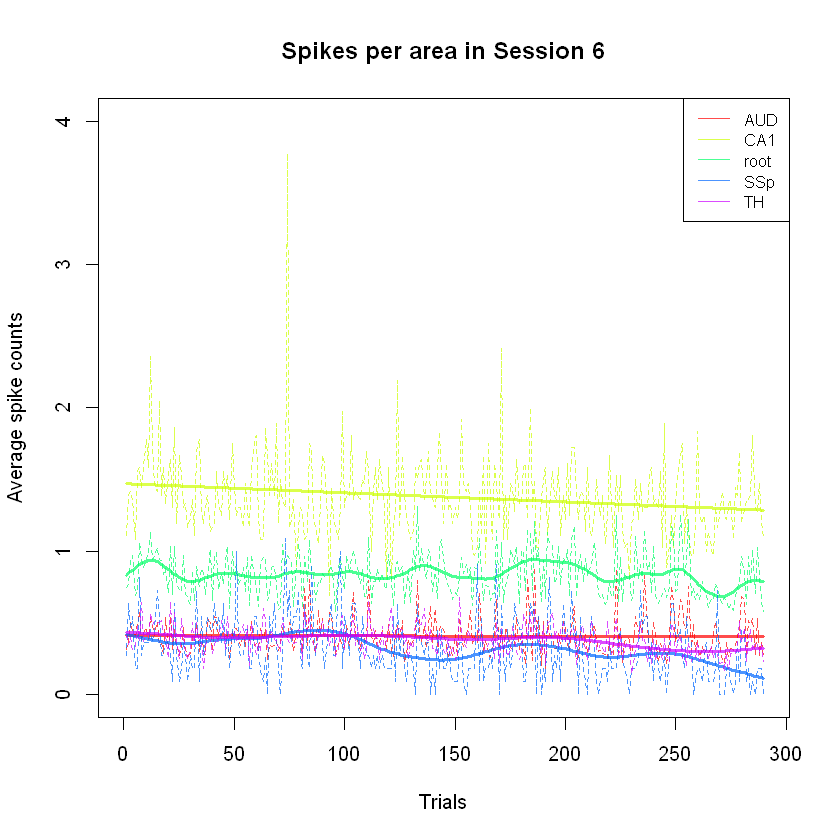

In [7]:
area.col = rainbow(n = n.area, alpha = 0.7)
plot(x = 1, y = 0, col = 'white', xlim = c(0, n.trial), ylim = c(0, 4.0), xlab = "Trials", ylab = "Average spike counts", main = paste("Spikes per area in Session", 6))


for(i in 1:n.area){
  lines(y = trial.summary[[i]], x = trial.summary$id, col = area.col[i], lty = 2, lwd = 1)
  lines(smooth.spline(trial.summary$id, trial.summary[[i]]),col = area.col[i], lwd = 3)
}

legend("topright", 
  legend = colnames(trial.summary)[1:n.area], 
  col = area.col, 
  lty = 1, 
  cex = 0.8
)

We see from the graph that the CA1 and root areas of the brain have significantly higher average spike counts than the rest of the areas. This plot however contains both the correct and incorrect trials for the session. We can now separate the correct and incorrect feedback and analyze the findings there as well.

In [8]:
trial.correct = trial.summary %>% filter(feedback == 1)

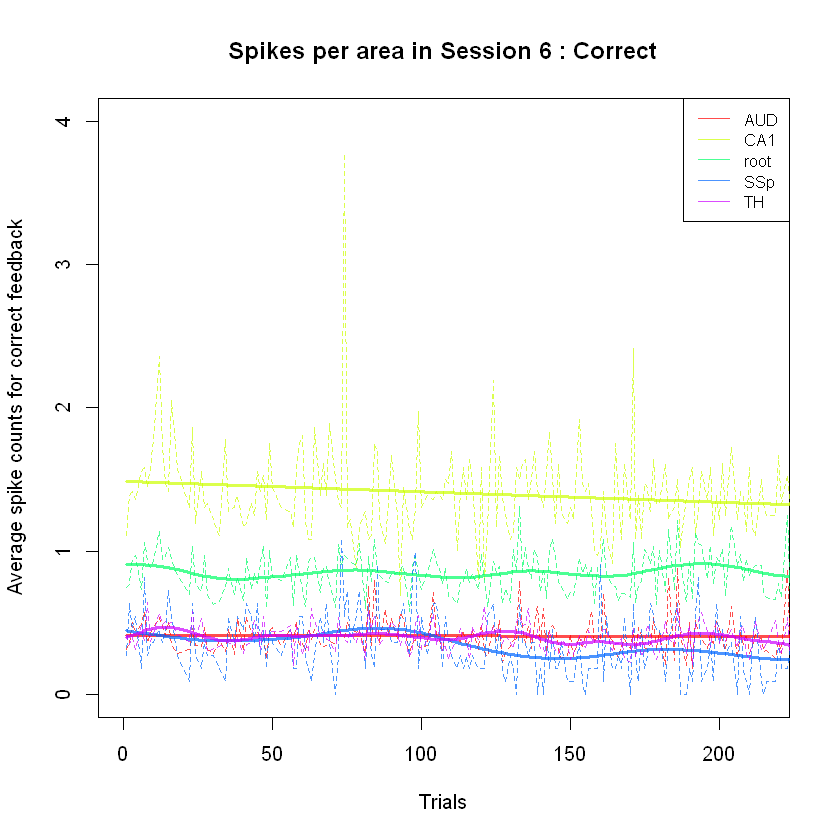

In [9]:
plot(x = 1, y = 0, col = 'white', xlim = c(0, dim(trial.correct)[1]), ylim = c(0, 4.0), xlab = "Trials", ylab = "Average spike counts for correct feedback", main = paste("Spikes per area in Session", 6, ": Correct"))


for(i in 1:n.area){
  lines(y = trial.correct[[i]], x = trial.correct$id, col = area.col[i], lty = 2, lwd = 1)
  lines(smooth.spline(trial.correct$id, trial.correct[[i]]),col = area.col[i], lwd = 3)
}

legend("topright", 
  legend = colnames(trial.correct)[1:n.area], 
  col = area.col, 
  lty = 1, 
  cex = 0.8
)

In [10]:
trial.incorrect = trial.summary %>% filter(feedback == -1)

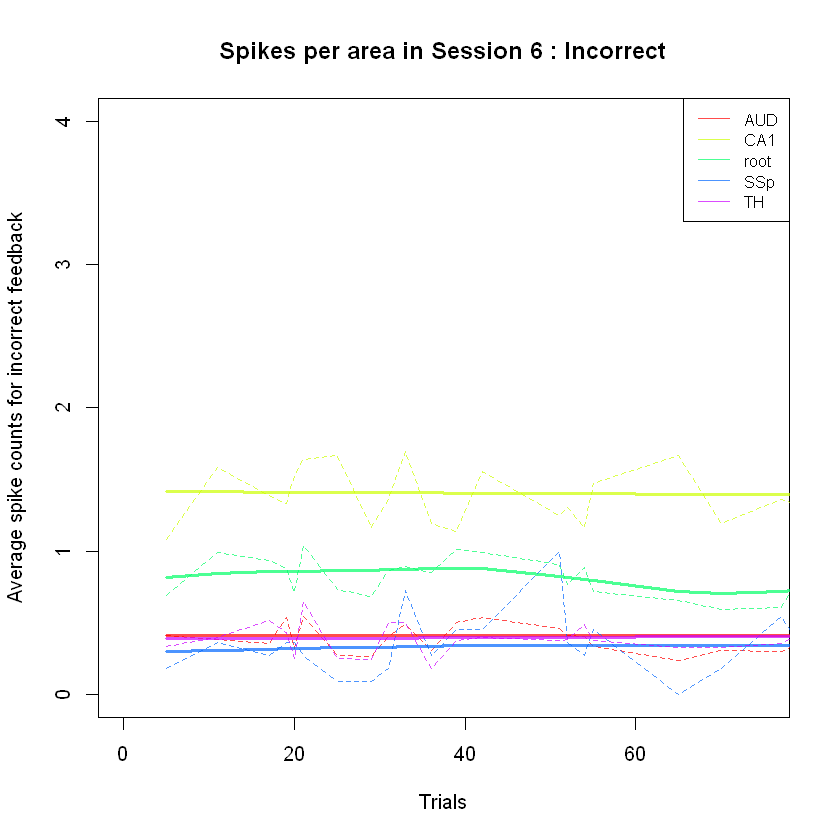

In [11]:
plot(x = 1, y = 0, col = 'white', xlim = c(0, dim(trial.incorrect)[1]), ylim = c(0, 4.0), xlab = "Trials", ylab = "Average spike counts for incorrect feedback", main = paste("Spikes per area in Session", 6, ": Incorrect"))


for(i in 1:n.area){
  lines(y = trial.incorrect[[i]], x = trial.incorrect$id, col = area.col[i], lty = 2, lwd = 1)
  lines(smooth.spline(trial.incorrect$id, trial.incorrect[[i]]),col = area.col[i], lwd = 3)
}

legend("topright", 
  legend = colnames(trial.incorrect)[1:n.area], 
  col = area.col, 
  lty = 1, 
  cex = 0.8
)

We see from these two plots that when we filter based on correct and incorrect feedback, the results look similar in the sense that CA1 and root had higher average spike counts than the other brain areas.

#### Data Across Neurons

Finally, we will explore our most granular data, neuron activity across a single trial. Since we are already given a matrix for a single trial, we can use it to visualize a 'map' of sorts that displays neuron activity as time progresses throughout the trial. We will need to compare both a correct and incorrect feedback. Thus, we will be examining trial 1 and trial 5 from session 6.

In [12]:
plot.trial <- function(i.t, area, area.col, this_session){
    
    spks = this_session$spks[[i.t]];
    n.neuron = dim(spks)[1]
    time.points = this_session$time[[i.t]]
    
    plot(0, 
         0, 
         xlim=c(min(time.points), max(time.points)),
         ylim=c(0, n.neuron + 1),
         col='white', 
         xlab='Time (s)',
         yaxt='n', 
         ylab='Neuron', 
         main=paste('Trial ',i.t, 'feedback', this_session$feedback_type[i.t] ),
         cex.lab=1.5)
    
    for(i in 1:n.neuron){
        i.a = which(area == this_session$brain_area[i]);
        col.this = area.col[i.a]
        
        ids.spike = which(spks[i,] > 0) # find out when there are spikes 
        if(length(ids.spike) > 0){
            points(x = time.points[ids.spike], 
                   y = rep(i, length(ids.spike)), 
                   pch='.', 
                   cex=2, 
                   col = col.this
                  )
        }
      
            
    }
    
legend("topright", 
  legend = area, 
  col = area.col, 
  pch = 16, 
  cex = 0.8
  )
}

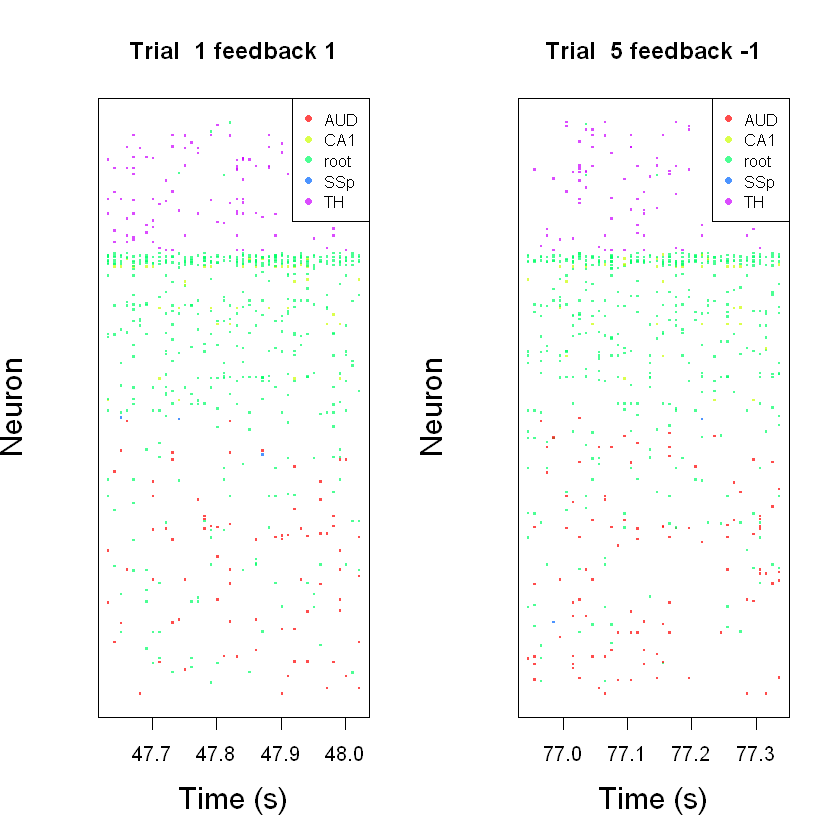

In [13]:
varname = names(trial.summary);
area = varname[1:(length(varname) - 4)]
par(mfrow=c(1, 2))
plot.trial(1, area, area.col, session[[6]])
plot.trial(5, area, area.col, session[[6]])

From these two graphs, we can see that for a correct feedback and incorrect feedback, the neuron activity are basically identical in respect to time. Thus, when we integrate the data, we will need to use many trials in order to distinguish a correct feedback from incorrect.

#### Homogeneity and Heterogeneity

When comparing across trials, we must take into consideration the similarities and differences across sessions. For each session, there is a different mouse. Additionally, each session records different brain areas.

In order to homogenize the different amount of trials and neurons, we averaged the total spikes of each bran region. Now, we have to combine all session data. This means that we must add other brain areas to sessions that do not have data for those areas. Therefore, we will assume that all neurons from the same area act the same for all the mice. We will replace those missing values with the means of the rest of the values in the data.

# Data Integration

Before creating a prediction model, we need to combine all the data from all the sessions. We will replace any missing values with the average of the values in the column. Then, we will use PCA to reduce the dimensions of the dataframe so that we can create the simplist prediction model.

In [16]:
data.frames = list()

for(i in 1:18) {
    n.trial.frame = pull(table.data[i, 6])
    n.area.frame = pull(table.data[i, 4])

    trial.summary.frame = matrix(nrow = n.trial.frame, ncol = n.area.frame + 1 + 2 + 1)
    for(i.t in 1:n.trial.frame){
      trial.summary.frame[i.t,] = c(average_spike_area(i.t,this_session = session[[i]]),
                              session[[i]]$feedback_type[i.t],
                              session[[i]]$contrast_left[i.t],
                              session[[i]]$contrast_right[i.t],
                              i.t)
    }

    colnames(trial.summary.frame) = c(names(average_spike_area(i.t, this_session = session[[i]])), 'feedback', 'left contr.','right contr.','id' )

    trial.summary.frame <- as_tibble(trial.summary.frame)
    data.frames[[i]] = trial.summary.frame
}

In [56]:
combined.data = merge(data.frames[[1]], data.frames[[2]], all = TRUE)

In [57]:
for(i in 3:18) {
    combined.data <- merge(combined.data, data.frames[[i]], all = TRUE)
}

In [58]:
head(combined.data)

,feedback,left contr.,right contr.,id,root,LGd,CA3,TH,ZI,CP,⋯,PAG,RSP,BLA,SSs,MEA,RT,ACB,OT,SI,SNr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1,0,0,1,1.072626,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,0.902439,1.75,NA,NA,NA,NA
2,-1,0,0,1,1.705202,1.073333,NA,NA,1.400000,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,-1,0,0,2,1.089888,NA,0.8461538,NA,NA,0.7457627,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,-1,0,0,2,1.170000,4.727273,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,-1,0,0,2,1.518072,1.388430,5.6666667,NA,2.636364,NA,⋯,NA,NA,1.151515,NA,NA,NA,NA,NA,NA,NA
6,-1,0,0,3,1.000000,NA,0.5461538,NA,NA,0.5423729,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Now that we have combined all the columns, we need to replace all the NA values with the mean of the column.

In [59]:
for(i in 1:ncol(combined.data)) {
    combined.data[, i] = ifelse(is.na(combined.data[, i]), ave(combined.data[, i], FUN = function(x) mean(x, na.rm = TRUE)), combined.data[, i])
}

In [60]:
head(combined.data)

,feedback,left contr.,right contr.,id,root,LGd,CA3,TH,ZI,CP,⋯,PAG,RSP,BLA,SSs,MEA,RT,ACB,OT,SI,SNr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1,0,0,1,1.072626,1.824642,2.1390903,0.9362962,2.005350,0.9825126,⋯,0.6655117,0.4842845,1.200908,0.6936905,0.9024390,1.750000,0.7946834,0.8513177,1.5625,1.081161
2,-1,0,0,1,1.705202,1.073333,2.1390903,0.9362962,1.400000,0.9825126,⋯,0.6655117,0.4842845,1.200908,0.6936905,0.9560105,1.290483,0.7946834,0.8513177,1.5625,1.081161
3,-1,0,0,2,1.089888,1.824642,0.8461538,0.9362962,2.005350,0.7457627,⋯,0.6655117,0.4842845,1.200908,0.6936905,0.9560105,1.290483,0.7946834,0.8513177,1.5625,1.081161
4,-1,0,0,2,1.170000,4.727273,2.1390903,0.9362962,2.005350,0.9825126,⋯,0.6655117,0.4842845,1.200908,0.6936905,0.9560105,1.290483,0.7946834,0.8513177,1.5625,1.081161
5,-1,0,0,2,1.518072,1.388430,5.6666667,0.9362962,2.636364,0.9825126,⋯,0.6655117,0.4842845,1.151515,0.6936905,0.9560105,1.290483,0.7946834,0.8513177,1.5625,1.081161
6,-1,0,0,3,1.000000,1.824642,0.5461538,0.9362962,2.005350,0.5423729,⋯,0.6655117,0.4842845,1.200908,0.6936905,0.9560105,1.290483,0.7946834,0.8513177,1.5625,1.081161


#### Reducing Dimensionality

Now that we have combined all the trials and removed any missing values, we need to reduce the dimensionality of this data by using PCA. PCA will allow us to single out the factors that contribute the most amount of variance. Eventually, we will use these factors to predict the mouse feedback.

We will extract the predictor variables (brain region activities) and scale them first.

In [31]:
combined.predictors <- combined.data[, 5:66]
combined.predictors.standardized <- scale(combined.predictors)
combined.pca <- prcomp(combined.predictors.standardized)

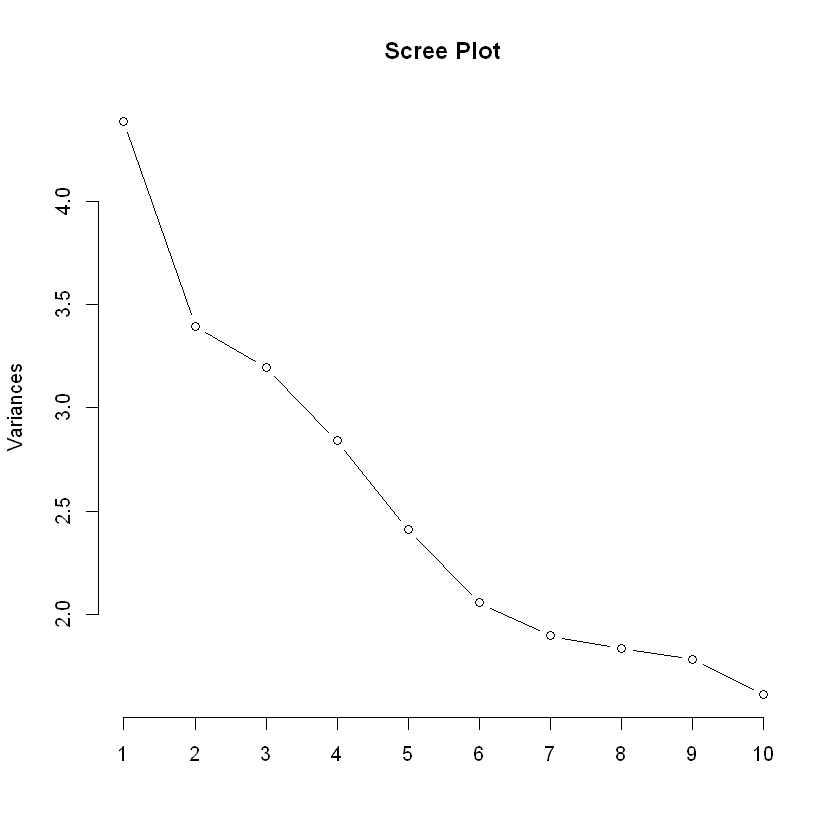

In [32]:
plot(combined.pca, type = "l", main = "Scree Plot")

After performing PCA and plotting the scree plot, we see that the first 6 PCA's represent the majority of the variances. We now need to relate these PCA's to the predictor variables. We can do this by contructing biplots of the PCA's.

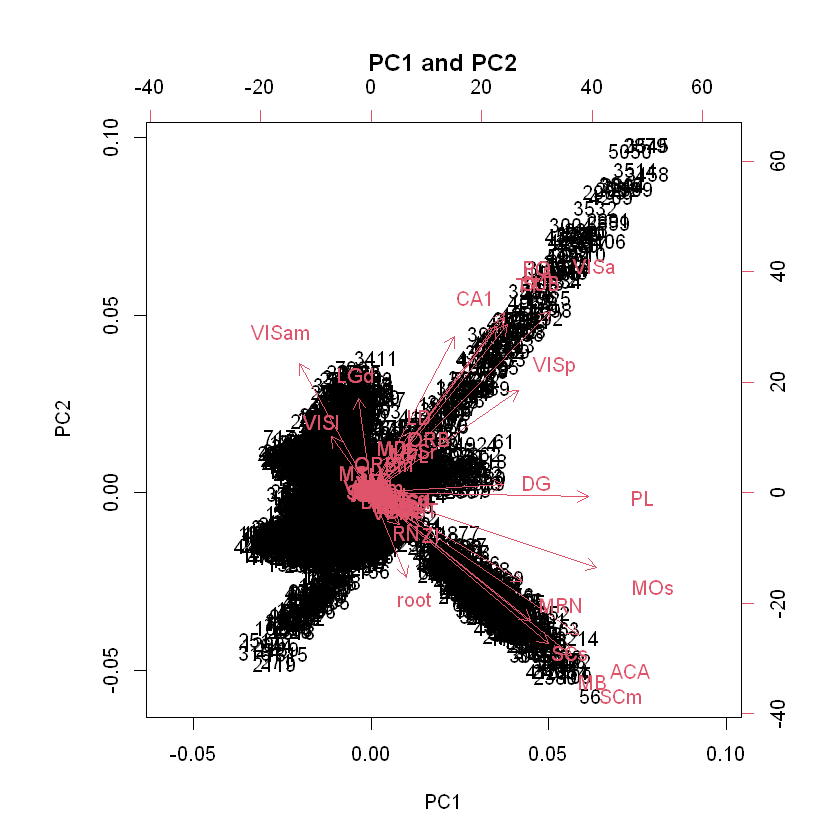

In [122]:
biplot(combined.pca, main = 'PC1 and PC2')

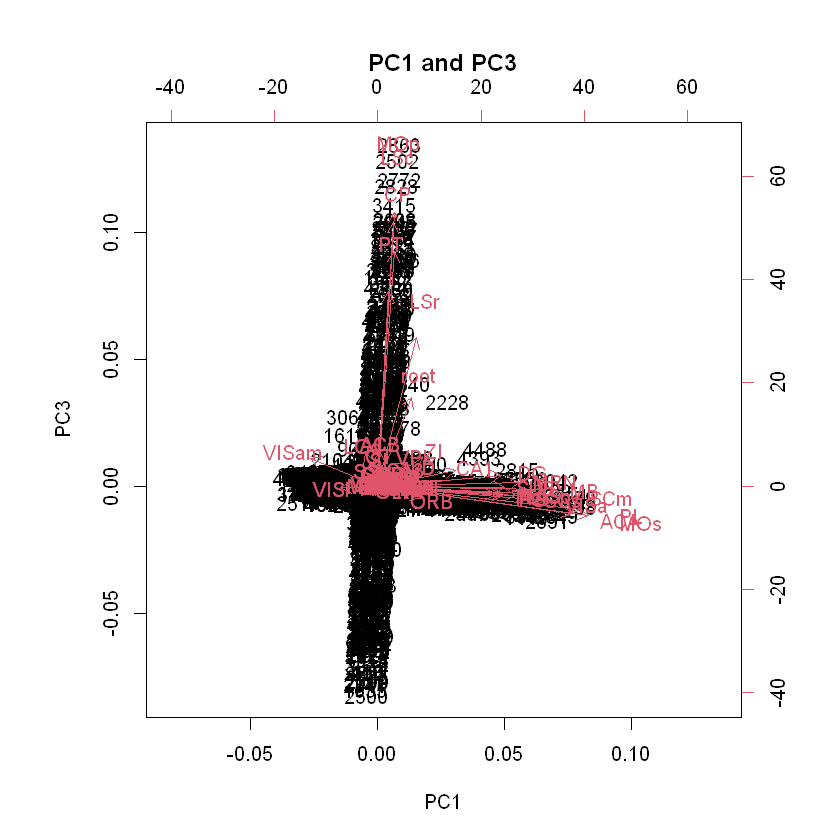

In [123]:
biplot(combined.pca, choices=c(1,3), main = 'PC1 and PC3')

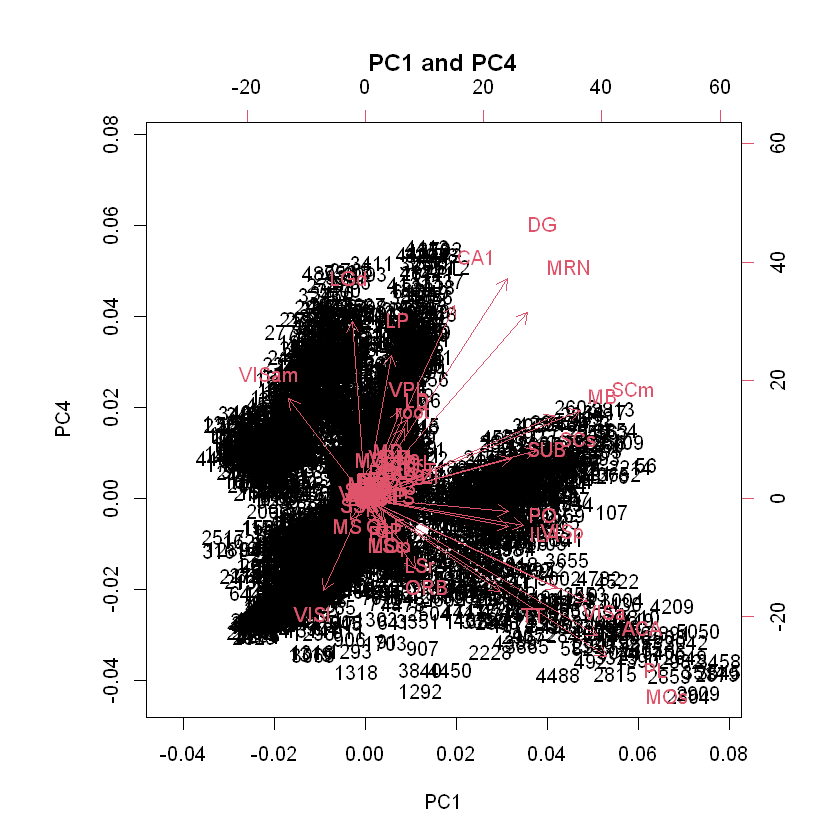

In [124]:
biplot(combined.pca, choices=c(1,4), main = 'PC1 and PC4')

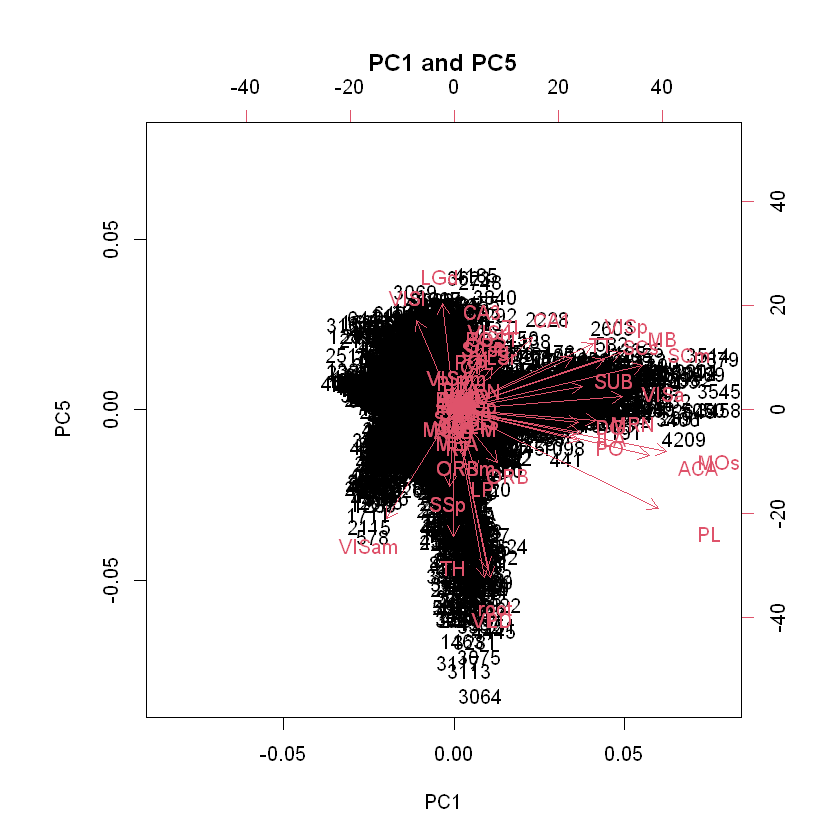

In [125]:
biplot(combined.pca, choices=c(1,5), main = 'PC1 and PC5')

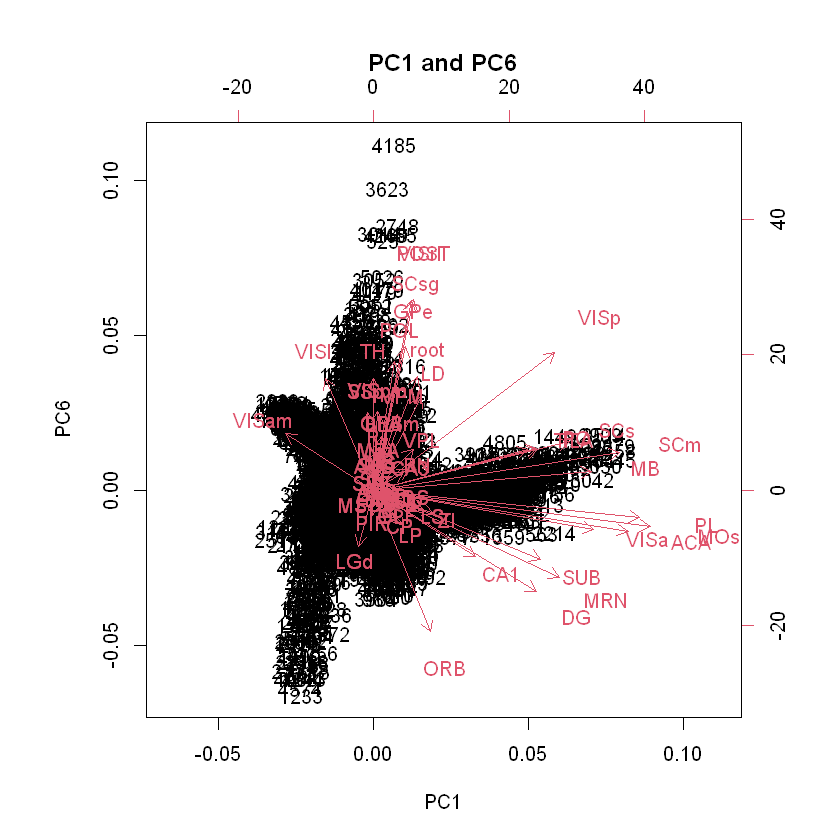

In [126]:
biplot(combined.pca, choices=c(1,6), main = 'PC1 and PC6')

After using the biplots, we come up with 27 areas of the brain that contribute to the PCA's. Thus, we can use these 27 areas as predictors for feedback. These areas are as follows:

 - VISa
 - SUB
 - PO
 - ILA
 - VISp
 - DG
 - PL
 - MOs
 - MRN
 - SCs
 - ACA
 - MB
 - SCm
 - VISam
 - LGd
 - CA1
 - LSr
 - PT
 - CP
 - LSc
 - MOp
 - LP
 - VISI
 - CA3
 - SCsg
 - POST
 - VISrl

# Predictive Modeling

Now that we have reduced the brain areas to 27 features, we can use them as predictor variables to create a predictive model. We will create 3 different models and evaluate their performances to pick the best performing model. We will use LDA, Logistic regression, and linear regression.

We will randomly sample 80% of our integrated data as training data and the other 20% will be treated as testing data. 

In [61]:
set.seed(10)

sample <- sample(c(TRUE, FALSE), nrow(combined.data), replace = TRUE, prob = c(0.8, 0.2))
train <- combined.data[sample, ]
test <- combined.data[!sample, ]

In [62]:
suppressWarnings(library(MASS))

In [63]:
train <- train[!is.infinite(rowSums(train)),]
train <- na.omit(train)

#### LDA

In [65]:
model <- lda(feedback ~ VISa + SUB + PO + ILA + VISp + DG + PL + MOs + MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + LSr + PT + CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + VISrl, data = train)
model

Call:
lda(feedback ~ VISa + SUB + PO + ILA + VISp + DG + PL + MOs + 
    MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + LSr + PT + 
    CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + VISrl, data = train)

Prior probabilities of groups:
       -1         1 
0.2907609 0.7092391 

Group means:
        VISa      SUB       PO      ILA     VISp       DG        PL       MOs
-1 0.9237811 1.407032 2.208648 1.406338 1.091361 1.568055 0.9844796 0.7069470
1  0.9443349 1.442358 2.230604 1.414218 1.128285 1.646866 1.0003664 0.7190374
        MRN      SCs       ACA       MB      SCm    VISam      LGd      CA1
-1 3.110324 1.786848 0.6377262 2.212787 1.830233 1.680216 1.800946 1.109248
1  3.232033 1.824720 0.6476984 2.317752 1.889207 1.711741 1.832973 1.188722
        LSr       PT        CP      LSc      MOp       LP     VISl      CA3
-1 1.321462 1.257321 0.9726617 1.081385 1.304376 2.692424 1.277878 2.038523
1  1.377597 1.261644 0.9873860 1.093871 1.318549 2.714149 1.284418 2.168028
       SCsg   

In [66]:
prediction <- (predict(model, newdata = test))$class
actual <- test$feedback

In [127]:
conf.table <- table(actual, prediction, dnn = c('-1', '1'))

#### Logistic Model

In [69]:
train.log <- train
train.log$feedback <- ifelse(train.log$feedback == -1, 0, 1)
model.log <- glm(feedback ~ VISa + SUB + PO + ILA + VISp + DG + PL + MOs + MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + LSr + PT + CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + VISrl, data = train.log, family = binomial)
model.log


Call:  glm(formula = feedback ~ VISa + SUB + PO + ILA + VISp + DG + 
    PL + MOs + MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + 
    LSr + PT + CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + 
    VISrl, family = binomial, data = train.log)

Coefficients:
(Intercept)         VISa          SUB           PO          ILA         VISp  
   -5.69865     -0.08173      0.21418      1.60620     -0.78441     -0.14320  
         DG           PL          MOs          MRN          SCs          ACA  
    0.02151     -0.23074      0.33686     -0.03974      0.20983     -0.02905  
         MB          SCm        VISam          LGd          CA1          LSr  
    0.31427      0.10163      0.73270     -0.12804      0.26485      0.08738  
         PT           CP          LSc          MOp           LP         VISl  
   -0.07361      0.29796      0.24678      0.34470     -0.07891      0.12465  
        CA3         SCsg         POST        VISrl  
    0.06806      0.43752      0.79434     -2.05686  

In [128]:
test.log <- test
test.log$feedback <- ifelse(test.log$feedback == -1, 0, 1)

prediction.log <- predict(model.log, newdata = test.log, type = "response")
prediction.log <- ifelse(prediction.log < 0.5, "0", "1")

actual.log <- test.log$feedback

conf.table.log <- table(actual.log, prediction.log, dnn = c('0', '1'))

#### Linear Model

In [73]:
model.lm <- lm(feedback ~ VISa + SUB + PO + ILA + VISp + DG + PL + MOs + MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + LSr + PT + CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + VISrl, data = train)
model.lm


Call:
lm(formula = feedback ~ VISa + SUB + PO + ILA + VISp + DG + PL + 
    MOs + MRN + SCs + ACA + MB + SCm + VISam + LGd + CA1 + LSr + 
    PT + CP + LSc + MOp + LP + VISl + CA3 + SCsg + POST + VISrl, 
    data = train)

Coefficients:
(Intercept)         VISa          SUB           PO          ILA         VISp  
 -2.1691176   -0.0719983    0.0953304    0.6278525   -0.2806266   -0.0559724  
         DG           PL          MOs          MRN          SCs          ACA  
  0.0058996   -0.0940317    0.1112884   -0.0127940    0.0694840   -0.0008352  
         MB          SCm        VISam          LGd          CA1          LSr  
  0.1238047    0.0464800    0.2811071   -0.0542799    0.1095577    0.0311752  
         PT           CP          LSc          MOp           LP         VISl  
 -0.0290912    0.0985641    0.1079161    0.1308512   -0.0313549    0.0617371  
        CA3         SCsg         POST        VISrl  
  0.0257653    0.1877567    0.3167857   -0.8465008  


In [76]:
prediction.lm <- (predict(model.lm, newdata = test))
prediction.lm <- ifelse(prediction.lm < 0.5, -1, 1)

actual.lm <- test$feedback

In [129]:
conf.table.lm <- table(actual.lm, prediction.lm, dnn = c('-1', '1'))

#### Comparing performance

To compare the performance of these three models, we will calculate the missclassification rate.

In [131]:
miss.rate.lda <- 1 - (sum(diag(conf.table)) / sum(conf.table))
cat('Miss rate LDA: ', miss.rate.lda)

Miss rate LDA:  0.2884802

In [132]:
miss.rate.log <- 1 - (sum(diag(conf.table.log)) / sum(conf.table.log))
cat('Miss rate logistic: ', miss.rate.log)

Miss rate logistic:  0.2894482

In [133]:
miss.rate.lm <- 1 - (sum(diag(conf.table.lm)) / sum(conf.table.lm))
cat('Miss rate linear: ', miss.rate.lm)

Miss rate linear:  0.5508228

We see that the miss rate for LDA and Logistic regression are nearly identical at 28%. Linear regression performed much worse at a 55% miss rate. For this analysis, we will choose LDA as our model of choice. 

Another observation to notice is that from the confusion table, the model is very good at predicting when a a feedback is supposed to be correct, but poor at predicting when a feedback is incorrect. This could be because we do not take into consideration the mice during the session.

# Prediction Performance

We will use the test sets provided to use test our model's performance. We first need to modify our test sets so that they can be accepted by the model.

In [81]:
testing = list()
for(i in 1:2){
  testing[[i]] = readRDS(paste('./Data/test', i, '.rds', sep = ''))
}

In [84]:
n.trial.test = length(testing[[1]]$feedback_type)
n.area.test = length(unique(testing[[1]]$brain_area))

test.summary.1 = matrix(nrow = n.trial.test, ncol = n.area.test + 1 + 2 + 1)
for(i.t in 1:n.trial.test){
  test.summary.1[i.t,] = c(average_spike_area(i.t,this_session = testing[[1]]),
                          testing[[1]]$feedback_type[i.t],
                          testing[[1]]$contrast_left[i.t],
                          testing[[1]]$contrast_right[i.t],
                          i.t)
}

colnames(test.summary.1) = c(names(average_spike_area(i.t, this_session = testing[[1]])), 'feedback', 'left contr.','right contr.','id' )

test.summary.1 <- as_tibble(test.summary.1)

In [87]:
n.trial.test = length(testing[[2]]$feedback_type)
n.area.test = length(unique(testing[[2]]$brain_area))

test.summary.2 = matrix(nrow = n.trial.test, ncol = n.area.test + 1 + 2 + 1)
for(i.t in 1:n.trial.test){
  test.summary.2[i.t,] = c(average_spike_area(i.t,this_session = testing[[2]]),
                          testing[[2]]$feedback_type[i.t],
                          testing[[2]]$contrast_left[i.t],
                          testing[[2]]$contrast_right[i.t],
                          i.t)
}

colnames(test.summary.2) = c(names(average_spike_area(i.t, this_session = testing[[2]])), 'feedback', 'left contr.','right contr.','id' )

test.summary.2 <- as_tibble(test.summary.2)

In [99]:
for(col in colnames(combined.data)) {
    if(!(col %in% colnames(test.summary.1))) {
        test.summary.1[[col]] <- rep(combined.data[[col]][1], 100)
    }
}

#### Model Performance metrics

Now that we have modified the data, we can pass them into the model and evaluate their performance. We will use 3 performance indicators:

 - Precision
 - Recall
 - F1-score

In [101]:
prediction.1 <- (predict(model, newdata = test.summary.1))$class
actual.1 <- test.summary.1$feedback

In [134]:
print('Confusion matrix: test set 1')
conf.table.1 <- table(actual.1, prediction.1, dnn = c('-1', '1'))
conf.table.1

[1] "Confusion matrix: test set 1"


    1
-1   -1  1
  -1  0 28
  1   0 72

In [103]:
for(col in colnames(combined.data)) {
    if(!(col %in% colnames(test.summary.2))) {
        test.summary.2[[col]] <- rep(combined.data[[col]][18], 100)
    }
}

In [104]:
prediction.2 <- (predict(model, newdata = test.summary.2))$class
actual.2 <- test.summary.2$feedback

In [135]:
print('Confusion matrix: test set 2')
conf.table.2 <- table(actual.2, prediction.2, dnn = c('-1', '1'))
conf.table.2

[1] "Confusion matrix: test set 2"


    1
-1   -1  1
  -1  0 27
  1   0 73

In [117]:
# Precision
prec.1 <- conf.table.1[2,2] / sum(conf.table.1[2,1:2])
prec.2 <- conf.table.2[2,2] / sum(conf.table.2[2,1:2])

In [118]:
# Recall
rec.1 <- conf.table.1[2,2] / sum(conf.table.1[1:2,2])
rec.2 <- conf.table.2[2,2] / sum(conf.table.2[1:2,2])

In [119]:
# f1 score
f1.1 <- 2 * prec.1 * rec.1 / (prec.1 + rec.1)
f1.2 <- 2 * prec.2 * rec.2 / (prec.2 + rec.2)

In [120]:
metrics <- data.frame(precision = c(prec.1, prec.2),
                     recall = c(rec.1, rec.2),
                     f1_score = c(f1.1, f1.2))
metrics

precision,recall,f1_score
<dbl>,<dbl>,<dbl>
1,0.72,0.8372093
1,0.73,0.8439306


From our performance metrics, we see that the model is fairly consistent across the two tests, as the precision, recall, and f-1 score are fairly high. The model is very good at predicting a correct positive as seen by the high precision score. However, it also predicts many false positives as seen by the lower recall score.

# Discussion

As seen in the previous section, we summarized our models performance using the precision, recall, and f1-score metrics. We see that our model predicts positive feedback extremely well, but is poor in predicting negative feedback. 

Some reasons for this could be that the brain activity for positive and negative trials were too similar, so the model cannot correctly distinguish the correct feedback. Some methods to improve the prediction of negative feedback could be to include the mouse name in the trial. Additionally, we could take measures to generalize some of the predictor variables such as mouse gender and brain region. Instead of using the specific brain area as a predictor, we can group them into their functional regions such as the brain areas that are responsible for visual identification.

Additionally, another feature we could add is time based brain activity. We could isolate the first 50 ms (which is responsible for detecting the stimuli).

# Conclusion

Throughout this analysis, we began by exploring the background of the experiement and similar research. Then, we explored the data on different scopes:
 - Across sessions
 - Across trials
 - Within a trial

After our exploration, we found that the brain areas all responses differently to differet stimuli. To combine them, we integrated the data with respect to the average spikes for every brain area. After integration, we used PCA to reduce the dimensionality of the data. From about 60 brain areas, we narrowed it down to 27 that contributed most to the variance in the data. Finally, we created a regression model with our training data.

To evaluate the performance of the model, we used the test sets provided. We found that the model was very good in predicting the positives, but was not good at predicting the negatives.